In [62]:
from utilities import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import reproject
import radio_beam
import os
from astropy.convolution import convolve
from astropy.io import fits
from astropy.wcs import WCS

plt.rcParams['figure.dpi'] = 300

source='DSVI'
fnum=fields[source]
central_pix=pixdict[source]
c2h5oh_sourcelocs={'DSi':'/oct2024_1_removesDS2exclusions/','DSii':'/oct2024_1_removeproblemlines/',
                   'DSiii':'/dec2024_3_try-close-to-FWZI/','DSiv':'/nov2024_1_firstrun_removesDS2exclusions/',
                   'DSVI':'/nov2024_1_removesDS2exclusions/'}
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/sep2023revolution/'#SgrB2S lives in the pacman_sep2023revolution folder, if we ever get to it
c2h5oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/C2H5OH/{source}'+c2h5oh_sourcelocs[source]
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}/{ch3oh_sourcedict[source]}'

In [63]:
path_nh2=ch3oh_datadir+'bootstrap_nh2map_3sigma_bolocamfeather_smoothedtobolocam.fits'
path_error_nh2=ch3oh_datadir+'bootstrap_nh2map_error_bolocamfeather_smoothedtobolocam.fits'

path_c2h5oh_trot=c2h5oh_datadir+'nc2h5oh_nch3oh_ratio_3sigma_lessthan1.fits'
path_error_c2h5oh_trot=c2h5oh_datadir+'nc2h5oh_nch3oh_ratio_error.fits'

In [84]:
hdu_nh2=fits.open(path_nh2)
beam_nh2=radio_beam.Beam.from_fits_header(hdu_nh2[0].header)
data_nh2=hdu_nh2[0].data
error_nh2=fits.getdata(path_error_nh2)
nh2wcs=WCS(hdu_nh2[0].header)

hdu_c2h5oh_trot=fits.open(path_c2h5oh_trot)
beam_c2h5oh_trot=radio_beam.Beam.from_fits_header(hdu_c2h5oh_trot[0].header)
data_c2h5oh_trot=hdu_c2h5oh_trot[0].data

hdu_error_c2h5oh_trot=fits.open(path_error_c2h5oh_trot)
beam_error_c2h5oh_trot=radio_beam.Beam.from_fits_header(hdu_error_c2h5oh_trot[0].header)
error_c2h5oh_trot=hdu_error_c2h5oh_trot[0].data

beam_deconv=beam_nh2.deconvolve(beam_c2h5oh_trot)
pixscale=WCS(hdu_c2h5oh_trot[0].header).proj_plane_pixel_area()**0.5

okmask=np.isfinite(data_c2h5oh_trot)*np.isfinite(data_nh2)
preconvolve_ok_trot=okmask*data_c2h5oh_trot
#sanity_error_mask=np.isfinite(error_c2h5oh_trot)*(error_c2h5oh_trot < 150)
#sanity_error_c2h5oh_trot=error_c2h5oh_trot*sanity_error_mask

nantreatment={'DSi':'fill','DSii':'fill','DSiv':'fill','DSVI':'fill'}
smoothed_c2h5oh_trot = convolve(preconvolve_ok_trot, beam_deconv.as_kernel(pixscale),nan_treatment=nantreatment[source])
#masked_smoothed_c2h5oh_trot=np.isfinite(data_nh2)*smoothed_c2h5oh_trot#*np.isfinite(preconvolve_ok_trot)
#masked_smoothed_c2h5oh_trot=smoothed_c2h5oh_trot*nh2mask
#okmaskc2h5ohtrot=np.ma.masked_where(okmask==False,smoothed_c2h5oh_trot)
#ok_smoothed_nc2h5oh=okmasknc2h5oh.filled(fill_value=np.nan)

#preconvolve_ok_error_nc2h5oh=okmask*error_nc2h5oh

uppersmoothedsnrcutoff={'DSi':7,'DSii':7,'DSiv':8,'DSVI':6}
smoothed_error_c2h5oh_trot = convolve(error_c2h5oh_trot, beam_deconv.as_kernel(pixscale),nan_treatment=nantreatment[source])#,mask=okmask,preserve_nan=True)
smoothed_snr=smoothed_c2h5oh_trot/smoothed_error_c2h5oh_trot
sigma3_data_c2h5oh_trot=smoothed_c2h5oh_trot*(smoothed_snr >= 3)*(smoothed_snr <= uppersmoothedsnrcutoff[source])
#okmaskerrornc2h5oh=np.ma.masked_where(okmask==False,smoothed_error_nc2h5oh)
#ok_smoothed_error_nc2h5oh=okmaskerrornc2h5oh.filled(fill_value=np.nan)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
invalid value encountered in divide


In [85]:
np.nanmin(smoothed_c2h5oh_trot/smoothed_error_c2h5oh_trot)

invalid value encountered in divide


0.0

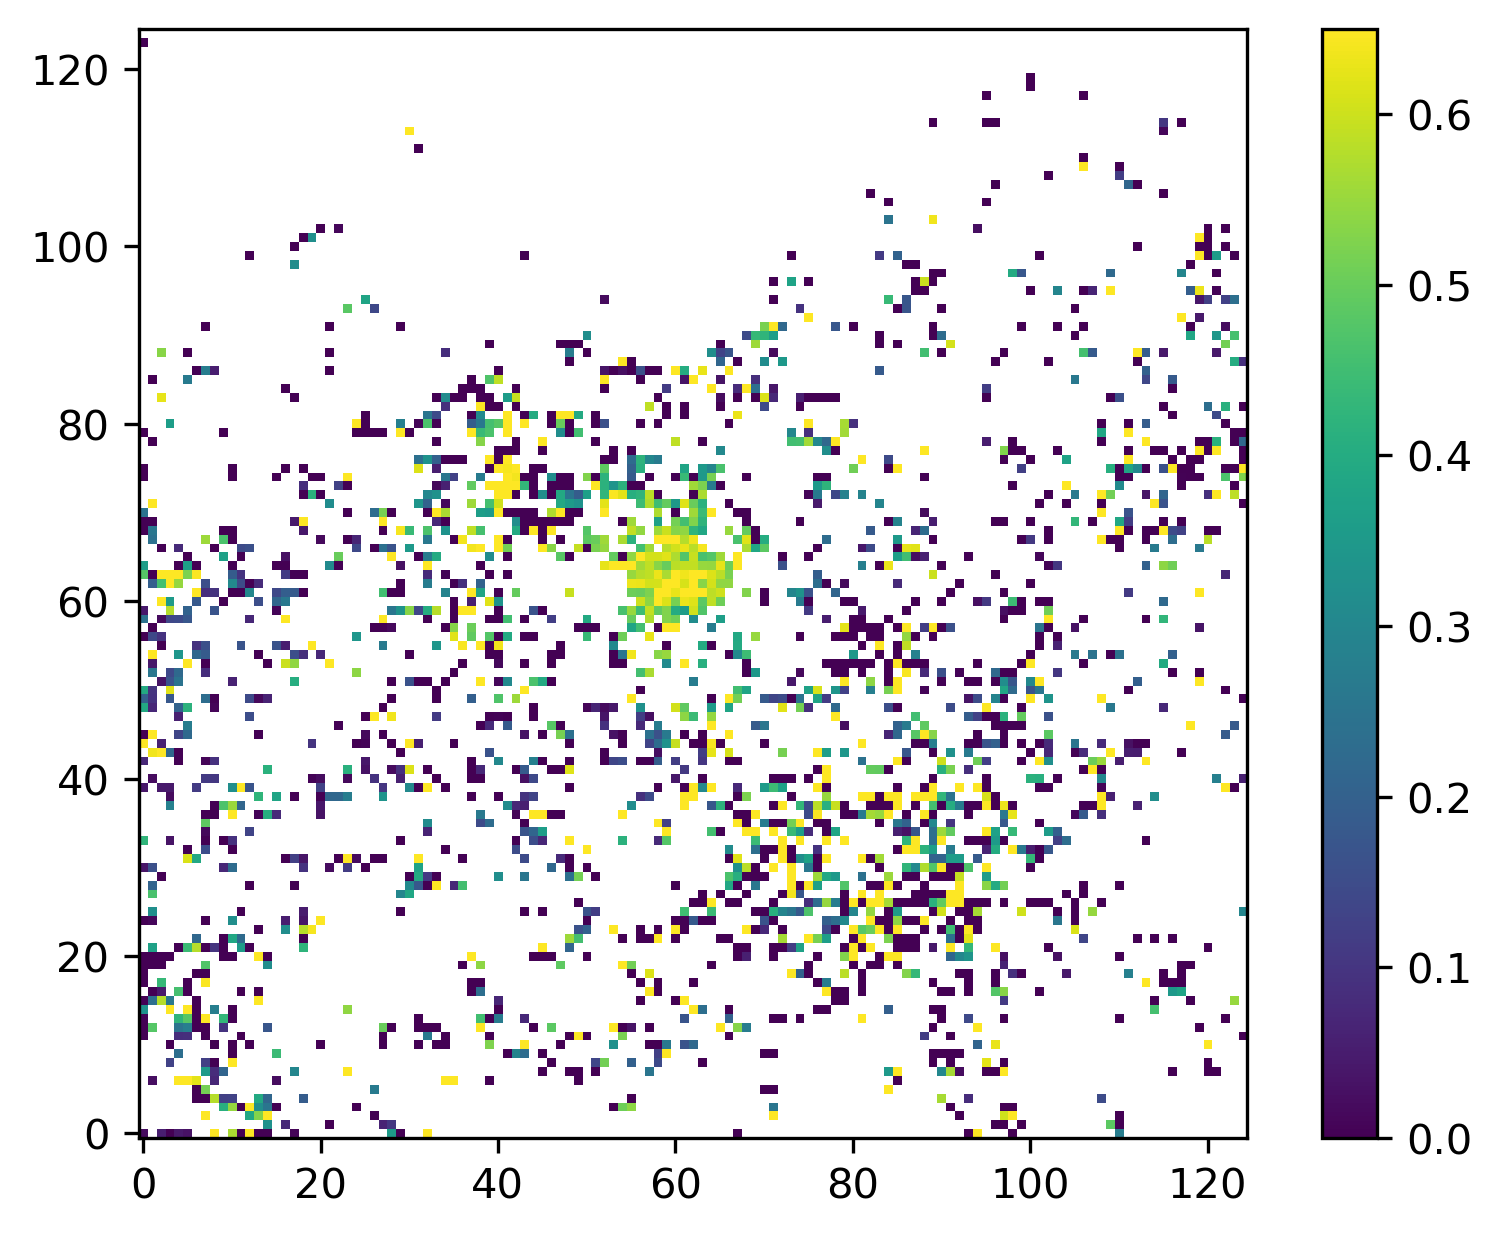

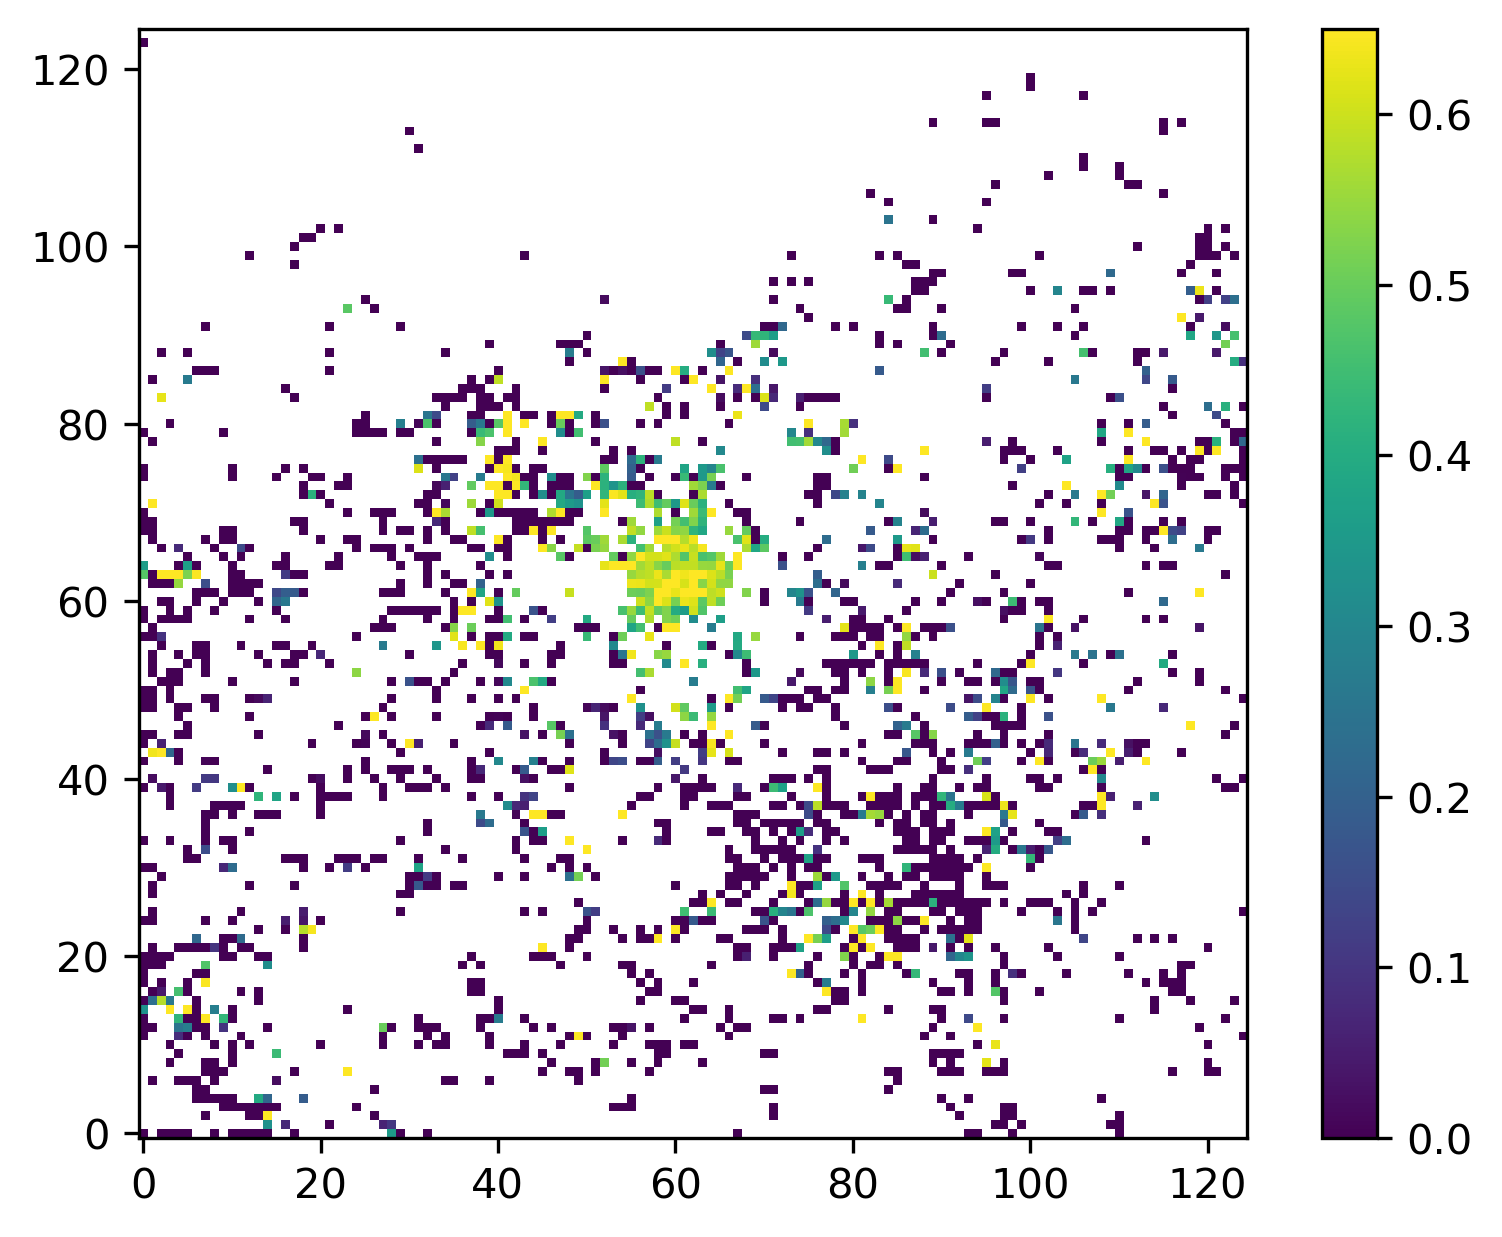

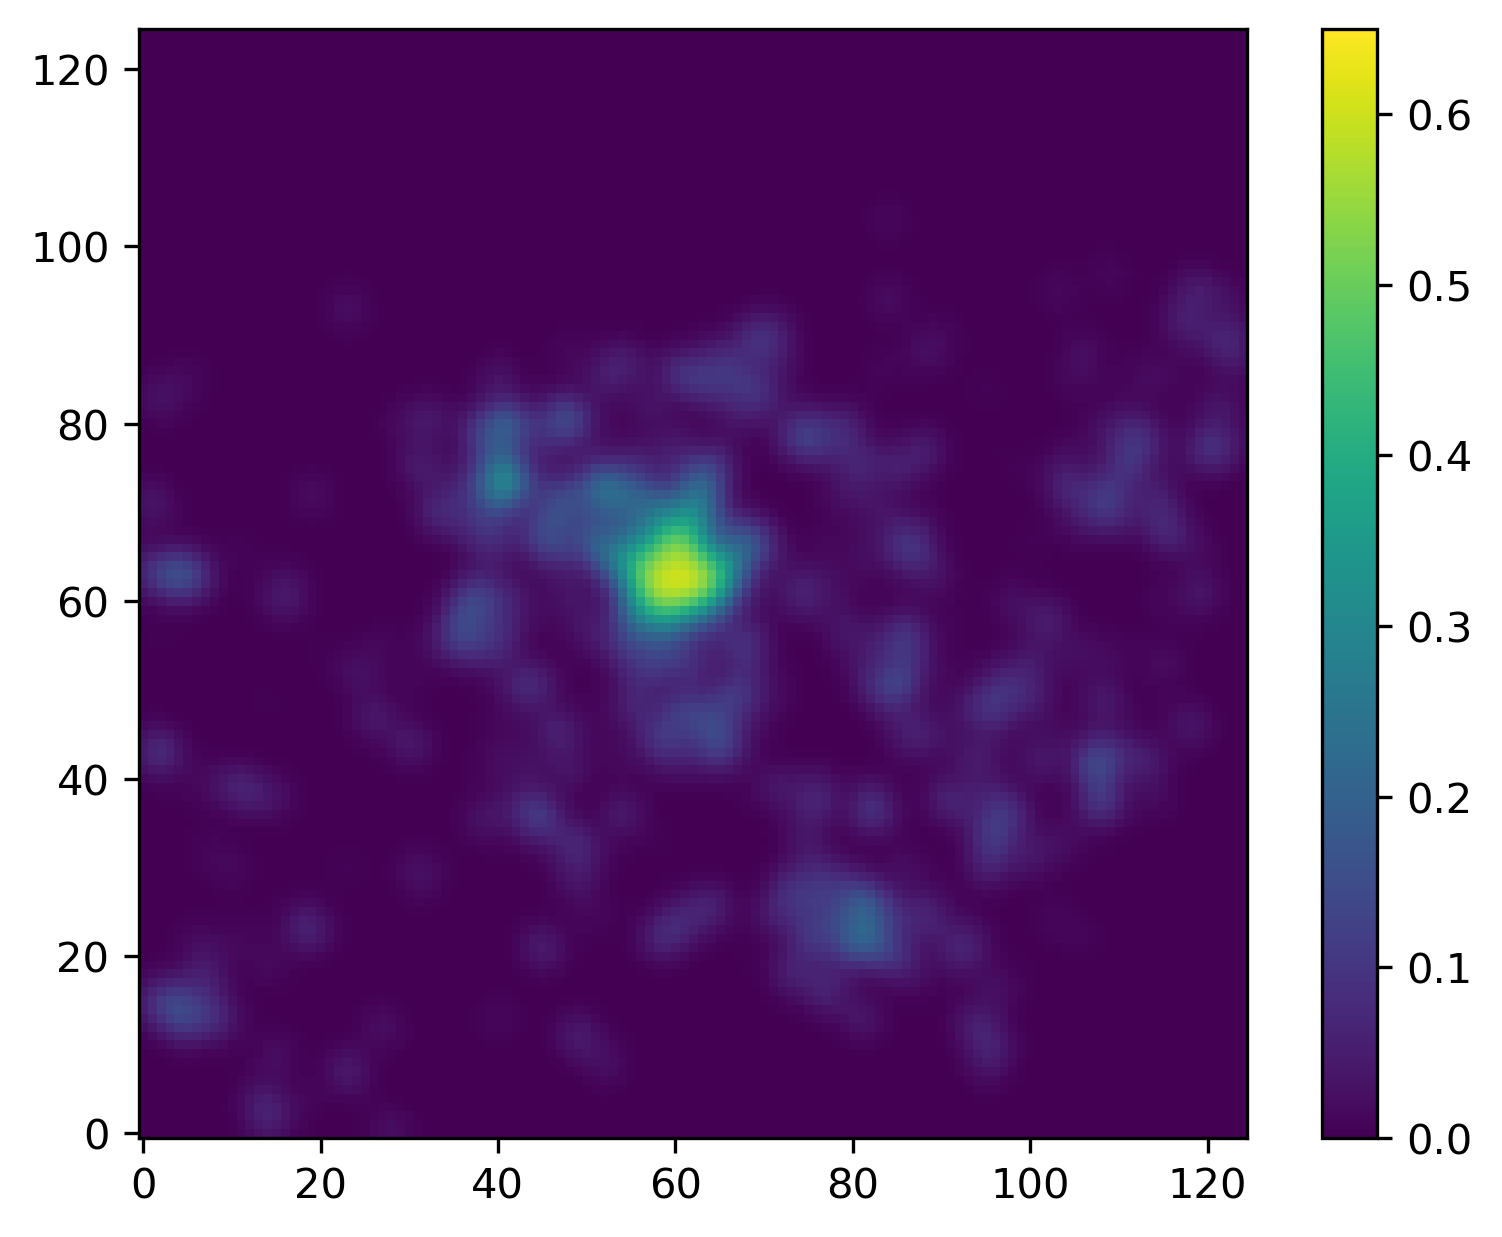

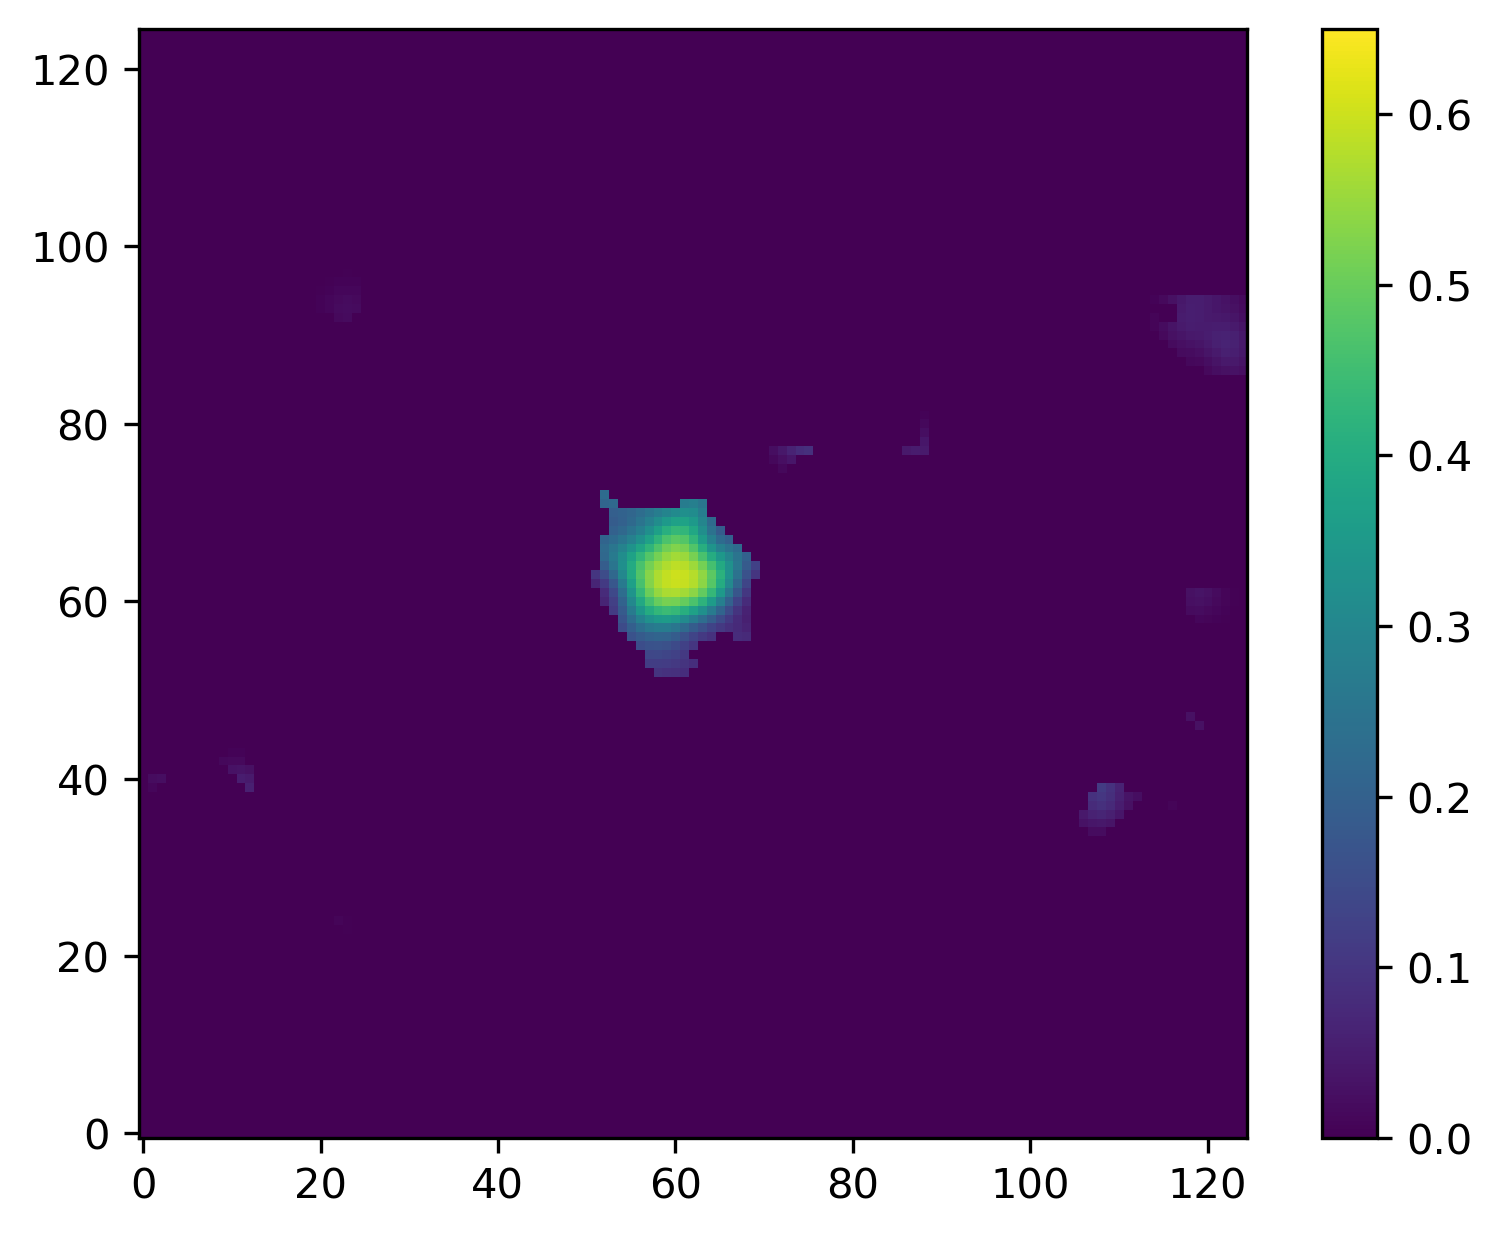

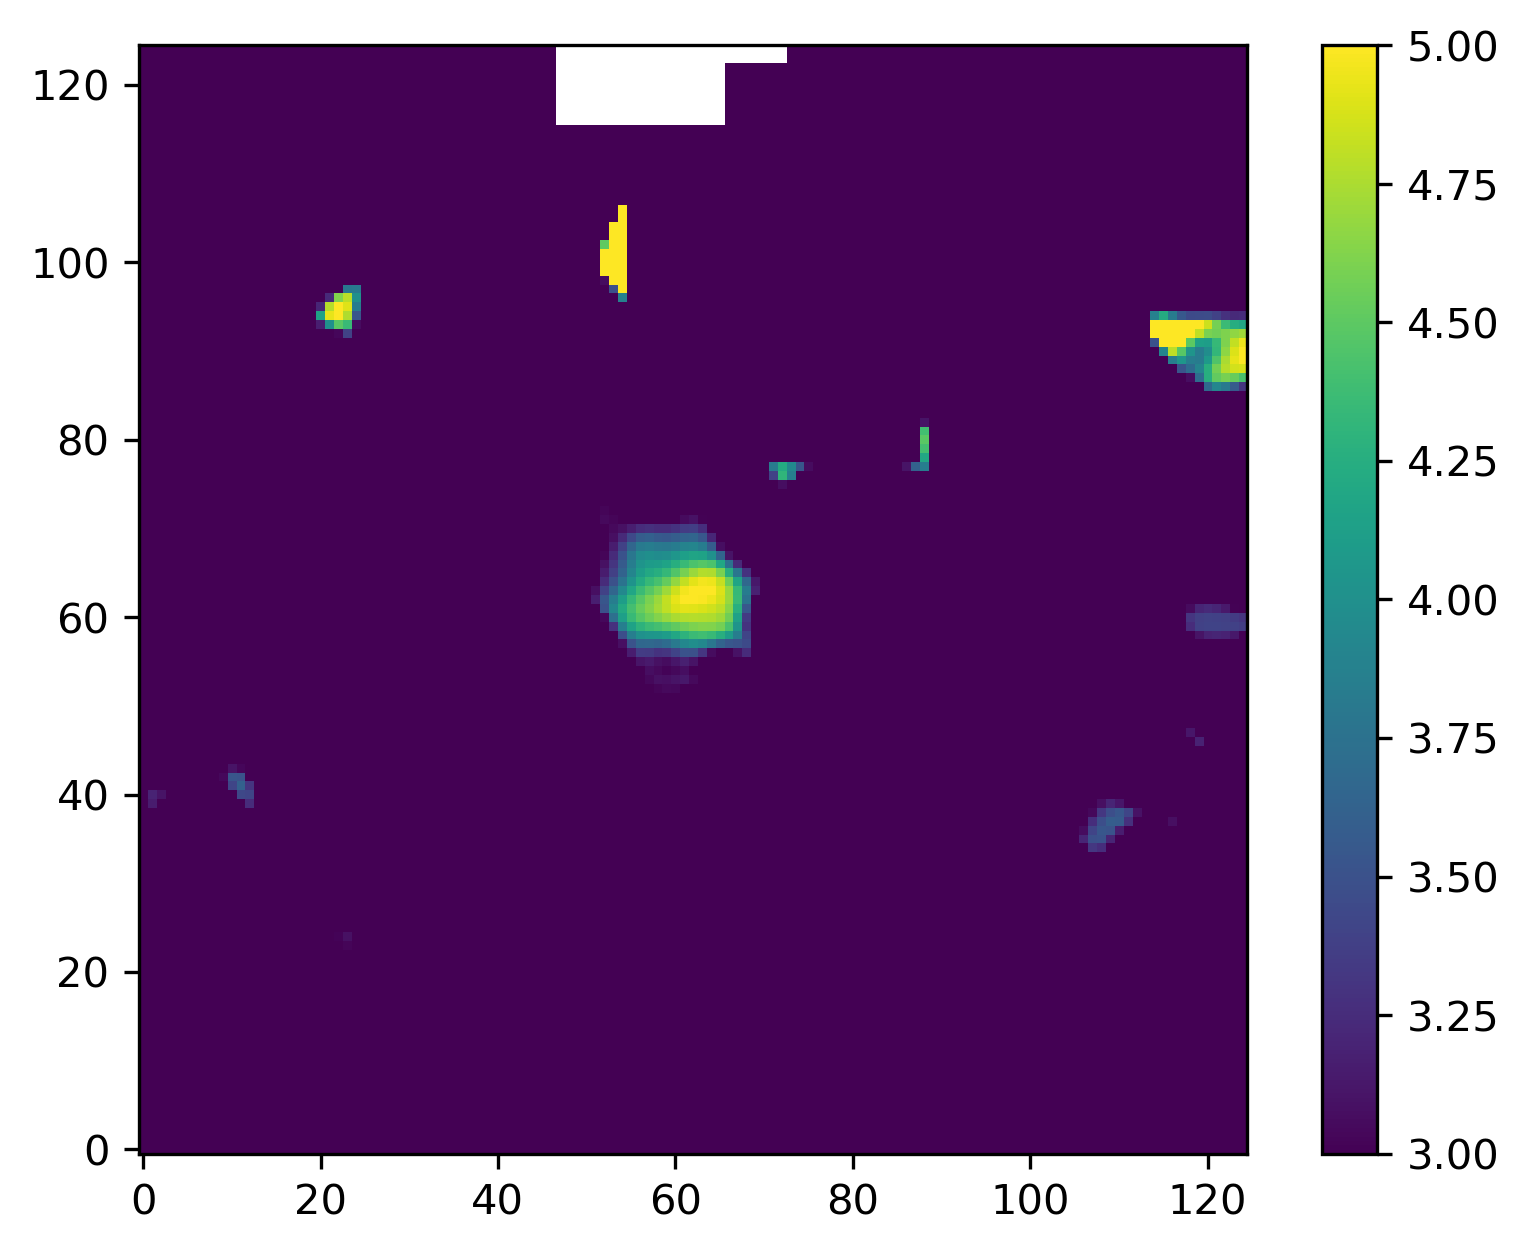

In [86]:
data_vmax=0.65

plt.imshow(data_c2h5oh_trot,origin='lower',vmax=data_vmax,)#cmap='inferno')
plt.colorbar()
plt.show()

plt.imshow(preconvolve_ok_trot,origin='lower',vmax=data_vmax,)#cmap='inferno')
plt.colorbar()
plt.show()

plt.imshow(smoothed_c2h5oh_trot,origin='lower',vmax=data_vmax,)#cmap='inferno')
plt.colorbar()
plt.show()


plt.imshow(sigma3_data_c2h5oh_trot,origin='lower',vmax=data_vmax,)
plt.colorbar()
plt.show()

plt.imshow(smoothed_snr,origin='lower',vmin=3,vmax=5)
plt.colorbar()
plt.show()


In [87]:
sigma3_c2h5ohabundprimaryhdu=fits.PrimaryHDU(sigma3_data_c2h5oh_trot)
sigma3_c2h5ohabundprimaryhdu.header=hdu_nh2[0].header
sigma3_c2h5ohabundprimaryhdu.header['BTYPE']='N(C2H5OH)/N(CH3OH)'
sigma3_c2h5ohabundprimaryhdu.header['BUNIT']=''
sigma3_c2h5ohabundhdul=fits.HDUList([sigma3_c2h5ohabundprimaryhdu])
sigma3_c2h5ohabundfitspath=c2h5oh_datadir+f'smoothed_nc2h5oh_nch3oh_ratio_{nantreatment[source]}_3sigma_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving 3sigma ratio map at {sigma3_c2h5ohabundfitspath}\n')
sigma3_c2h5ohabundhdul.writeto(sigma3_c2h5ohabundfitspath,overwrite=True)

c2h5ohabundprimaryhdu=fits.PrimaryHDU(smoothed_c2h5oh_trot)
c2h5ohabundprimaryhdu.header=hdu_nh2[0].header
c2h5ohabundprimaryhdu.header['BTYPE']='N(C2H5OH)/N(CH3OH)'
c2h5ohabundprimaryhdu.header['BUNIT']=''
c2h5ohabundhdul=fits.HDUList([c2h5ohabundprimaryhdu])
c2h5ohabundfitspath=c2h5oh_datadir+f'smoothed_nc2h5oh_nch3oh_ratio_{nantreatment[source]}_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving ratio map at {c2h5ohabundfitspath}\n')
c2h5ohabundhdul.writeto(c2h5ohabundfitspath,overwrite=True)


errc2h5ohabundprimaryhdu=fits.PrimaryHDU(smoothed_error_c2h5oh_trot)
errc2h5ohabundprimaryhdu.header=hdu_nh2[0].header
errc2h5ohabundprimaryhdu.header['BTYPE']='N(C2H5OH)/N(CH3OH) Error'
errc2h5ohabundprimaryhdu.header['BUNIT']=''
errc2h5ohabundhdul=fits.HDUList([errc2h5ohabundprimaryhdu])
errc2h5ohabundfitspath=c2h5oh_datadir+f'smoothed_nc2h5oh_nch3oh_ratio_error_{nantreatment[source]}_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving ratio map at {errc2h5ohabundfitspath}\n')
errc2h5ohabundhdul.writeto(errc2h5ohabundfitspath,overwrite=True)

Saving 3sigma ratio map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field2/C2H5OH/DSVI/nov2024_1_removesDS2exclusions/smoothed_nc2h5oh_nch3oh_ratio_fill_3sigma_bolocamfeather_smoothedtobolocam.fits

Saving ratio map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field2/C2H5OH/DSVI/nov2024_1_removesDS2exclusions/smoothed_nc2h5oh_nch3oh_ratio_fill_bolocamfeather_smoothedtobolocam.fits

Saving ratio map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field2/C2H5OH/DSVI/nov2024_1_removesDS2exclusions/smoothed_nc2h5oh_nch3oh_ratio_error_fill_bolocamfeather_smoothedtobolocam.fits

